In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import logging

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.delphes import DelphesProcessor
from madminer.sampling import combine_and_shuffle
from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge


In [7]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 8. Check model response with various toys at different parameter values

Generate a grid of parameter settings at which the model response will be tested. They need to be in an array, with each element of the array corresponding to an array of parameter values, e.g. for 3 parameters evaluated at `n` different points, the array is:

```python
[[param_1_point_1, param_2_point_1, param_3_point_1],
 [param_1_point_2, param_2_point_2, param_3_point_2],
 ...
 [param_1_point_n, param_2_point_n, param_3_point_n],
```

In [8]:
theta_each = np.linspace(0.,1.,21)
#theta0, theta1 = np.meshgrid(theta_each, theta_each)
#theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
theta_grid = np.array([theta_each]).T
print(theta_each)
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


`forge.evaluate(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood and 25\*100 estimates for the  score, both indexed by `[i_theta,i_x]`.

In [9]:
forge = MLForge()
forge.load('models/model')

log_r_hat, _, _ = forge.evaluate(
    theta0_filename='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

log_r_hat_bsm, _, _ = forge.evaluate(
    theta0_filename='data/samples/theta_grid.npy',
    x='data/samples/x_test_bsm.npy',
    evaluate_score=False
)

log_r_hat_bsm_morph, _, _ = forge.evaluate(
    theta0_filename='data/samples/theta_grid.npy',
    x='data/samples/x_test_bsm_morph.npy',
    evaluate_score=False
)

Let's look at the result:

CP even: [-0.85387665 -0.844206   -0.80988526 -0.7520385  -0.6743574  -0.5829592
 -0.4854864  -0.38962823 -0.30162624 -0.22537728 -0.16237237 -0.11225214
 -0.07356548 -0.04442239 -0.02292278 -0.00737843  0.00360843  0.0111461
  0.0160905   0.01909277  0.02064487]
CP odd: [0.45866176 0.480044   0.49819863 0.5120189  0.52036184 0.5220978
 0.51630676 0.5025514  0.4810875  0.45288852 0.41947246 0.38262036
 0.34409878 0.3054574  0.2679228  0.23237208 0.19936028 0.169175
 0.14189994 0.1174749  0.09574699]
mixed: [-0.01881346 -0.00118703  0.02320839  0.05329679  0.08705959  0.12160255
  0.15358776  0.17993532  0.19850661  0.20846438  0.21020313  0.20497641
  0.19444323  0.18029572  0.16402866  0.14683674  0.12960002  0.11291799
  0.0971636   0.08253952  0.06912847]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
best fit point for CP even at: [1.]
best fit point for CP odd at: [0.25]
best fit point for mixed at: [0.5]


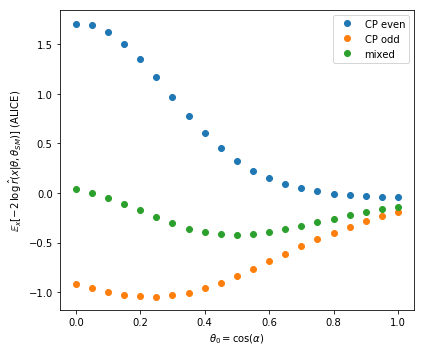

In [10]:
#bin_size = theta_each[1] - theta_each[0]
#edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
#ax = plt.gca()

expected_llr           = np.mean(log_r_hat,axis=1)
expected_llr_bsm       = np.mean(log_r_hat_bsm,axis=1)
expected_llr_bsm_morph = np.mean(log_r_hat_bsm_morph,axis=1)

best_fit           = theta_grid[np.argmin(-2.*expected_llr)]
best_fit_bsm       = theta_grid[np.argmin(-2.*expected_llr_bsm)]
best_fit_bsm_morph = theta_grid[np.argmin(-2.*expected_llr_bsm_morph)]

#cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)

print("CP even:", expected_llr)
print("CP odd:", expected_llr_bsm)
print("mixed:", expected_llr_bsm_morph)
print(theta_each)
print("best fit point for CP even at:", best_fit)
print("best fit point for CP odd at:", best_fit_bsm)
print("best fit point for mixed at:", best_fit_bsm_morph)

plt.plot(theta_each, -2*expected_llr, "o", label='CP even')
plt.plot(theta_each, -2*expected_llr_bsm, "o", label='CP odd')
plt.plot(theta_each, -2*expected_llr_bsm_morph, "o", label='mixed')

#pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((15,15)),
#                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
#                    cmap='viridis_r')
#cbar = fig.colorbar(pcm, ax=ax, extend='both')
#
#plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0 = \cos\left(\alpha\right)$')
#plt.ylabel(r'$\theta_1$')
plt.ylabel(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$ (ALICE)')

plt.legend()
plt.tight_layout()
plt.show()


That's it for now. Please have a look at the documentation for a detailed description of all classes and functions. And if you're curious about SALLY, Fisher information matrices, and ensemble methods, please look at the second part of the tutorial!